In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
df = pd.read_csv('data/faers_filtered_adalimumab_2020-2024_grouped.csv')

In [3]:
df.isna().sum() / len(df) * 100

primaryid       0.000000
caseid          0.000000
caseversion     0.000000
event_dt       60.442913
init_fda_dt     0.000000
fda_dt          0.000000
age            41.963818
age_cod        41.963498
age_grp        88.897394
sex            11.049600
wt             69.829788
wt_cod         69.829788
rept_dt         0.003843
occp_cod        2.431232
seq             0.000000
role_cod        0.000000
drugname        0.000000
prod_ai         0.000000
route           7.668262
dose_vbm       42.888622
dose_amt       51.635581
dose_unit      49.562740
dose_form      31.233536
dose_freq      76.679899
indi_pt        29.183755
outc_cod       20.976304
pt              0.000000
start_dt       68.656609
end_dt         87.989565
dtype: float64

In [4]:
# Drop columns that are not needed for the project
data = df.drop(columns=['event_dt', 'wt', 'wt_cod', 'start_dt', 'end_dt', 'dose_vbm', 'dose_amt', 
                        'dose_unit', 'dose_form', 'dose_freq'])

In [5]:
len(data), data['primaryid'].nunique()

(624457, 299225)

In [6]:
# Count number of columns and rows
print(f'Number of columns: {len(data.columns)}')

Number of columns: 19


In [7]:
# Lowercase 
data = data.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

In [8]:
# Check for duplicates
data.duplicated().sum()

np.int64(834)

In [9]:
# Drop duplicates
data = data.drop_duplicates()

In [10]:
data['primaryid'].nunique(), data['caseid'].nunique()

(299225, 257274)

In [11]:
pd.set_option('display.max_columns', None)

# Display the first 5 rows
data.head(5)

,primaryid,caseid,caseversion,init_fda_dt,fda_dt,age,age_cod,age_grp,sex,rept_dt,occp_cod,seq,role_cod,drugname,prod_ai,route,indi_pt,outc_cod,pt
0,100735935,10073593,5,20140411,20200326,55.0,yr,NaN,f,20200326.0,cn,1,ps,humira,adalimumab,subcutaneous,rheumatoid arthritis,ot,"['arterial occlusive disease', 'carotid artery..."
1,100735935,10073593,5,20140411,20200326,55.0,yr,NaN,f,20200326.0,cn,1,ps,humira,adalimumab,subcutaneous,rheumatoid arthritis,ho,"['arterial occlusive disease', 'carotid artery..."
2,100735935,10073593,5,20140411,20200326,55.0,yr,NaN,f,20200326.0,cn,2,ss,humira,adalimumab,subcutaneous,NaN,ot,"['arterial occlusive disease', 'carotid artery..."
3,100735935,10073593,5,20140411,20200326,55.0,yr,NaN,f,20200326.0,cn,2,ss,humira,adalimumab,subcutaneous,NaN,ho,"['arterial occlusive disease', 'carotid artery..."
4,102775337,10277533,7,20140703,20200124,40.0,yr,NaN,m,20200124.0,md,1,ps,humira,adalimumab,subcutaneous,crohn's disease,ho,"['anal incontinence', 'constipation', 'defaeca..."


### 1. Missing values in indi_pt

In [12]:
# Drop all missing values in 'indi_pt' column
indi_pt_missing = data.loc[data['indi_pt'].isnull() | 
                             (data['indi_pt'] == 'product used for unknown indication')]

mask = data.isin(indi_pt_missing.to_dict(orient='list')).all(axis=1)
data_2 = data[~mask]

In [13]:
len(data[mask])

248575

### 2. Date in init_fda_dt, fda_dt, rept_dt

In [14]:
# Convert 'rept_dt' to datetime
data_2['rept_dt'] = data_2['rept_dt'].astype(str).str.replace(r'\.0$', '', regex=True) # Remove trailing .0
data_2['rept_dt'] = pd.to_datetime(data_2['rept_dt'], format='%Y%m%d', errors='coerce')

# Replace missing dates in 'rept_dt' with 'fda_dt'
data_2['rept_dt'] = data_2['rept_dt'].fillna(data_2['fda_dt'])

# Get the number of reports per year
data_2['rept_yr'] = pd.to_datetime(data_2['rept_dt']).dt.year

In [15]:
# Drop 'init_fda_dt', 'fda_dt', 'rept_dt' column
data_2 = data_2.drop(columns=['init_fda_dt', 'fda_dt', 'rept_dt'])

In [16]:
# Drop all rports before 2020
data_2 = data_2[data_2['rept_yr'] >= 2020]

In [17]:
data_2['rept_yr'].value_counts()

rept_yr
2022    98068
2024    78018
2023    71159
2020    68395
2021    59207
2025       14
Name: count, dtype: int64

### 3. Missing values in occp_cod, sex, outc_cod

In [18]:
# Function to replace 'unk' values with the ratio of the remaining values
def replace_unk(data, column, unknown='unk'):
    # Fill missing values with value
    data[column] = data[column].fillna(unknown)

    # Count
    val_count = data[column].value_counts()
    unk_count = val_count[unknown]
    val_count = val_count.drop(unknown)
    val_ratio = val_count / val_count.sum()

    # Replace 'unk' values with the ratio of the remaining values
    replacement_val = np.random.choice(val_ratio.index, size=unk_count, p=val_ratio.values)

    unk_index = data.loc[data[column] == unknown].index
    data.loc[unk_index, column] = replacement_val

    return data

In [19]:
data_2[['occp_cod', 'sex', 'outc_cod']].isna().sum() / len(data_2) * 100

occp_cod     3.375118
sex          9.024945
outc_cod    26.715769
dtype: float64

In [20]:
data_2['occp_cod'].value_counts()

occp_cod
cn    208865
hp    105252
md     45075
ph      2862
lw       155
Name: count, dtype: int64

In [21]:
# Fill missing values in the 'occp_cod' column
data_2 = replace_unk(data_2, 'occp_cod', 'unk')

In [22]:
data_2['sex'].isna().sum()

np.int64(33831)

In [23]:
# Mapping dictionary
occp_mapping = {
    'md': 'physician',
    'ph': 'pharmacist',
    'ot': 'other health-professional',
    'lw': 'lawyer',
    'cn': 'consumer',
    'unk': 'unknown'
}

# Map 'occp_cod' to full text
data_2['occp_cod'] = data_2['occp_cod'].map(occp_mapping)

In [24]:
data_2['sex'].value_counts()

sex
f      244226
m       96775
unk        29
Name: count, dtype: int64

In [25]:
# Fill missing values in the 'sex' column
data_2 = replace_unk(data_2, 'sex', 'unk')

In [26]:
# Mapping dictionary
sex_mapping = {
    'f': 'female',
    'm': 'male'
}

# Map 'sex' to full text
data_2['sex'] = data_2['sex'].map(sex_mapping)

In [27]:
data_2['outc_cod'].value_counts()

outc_cod
ot    147818
ho     70831
ds     20322
de     17605
lt     14575
ca      3364
ri       199
Name: count, dtype: int64

In [28]:
# Fill missing values in the 'outc_cod' column
data_2 = replace_unk(data_2, 'outc_cod', 'unk')

### 4. Drop contaminant and interacting in role_cod

In [29]:
# Drop 'c' and 'i' rows in role_cod
data_2 = data_2[~data_2['role_cod'].isin(['c', 'i'])]

### 5. Synchronize values in age, age_cod, age_grp

In [30]:
data_2[['age', 'age_cod', 'age_grp']].isna().sum() / len(data_2) * 100

age        44.455848
age_cod    44.455301
age_grp    91.342556
dtype: float64

In [31]:
data_2[['age', 'age_cod', 'age_grp']].head(5)

,age,age_cod,age_grp
0,55.0,yr,NaN
1,55.0,yr,NaN
4,40.0,yr,NaN
5,40.0,yr,NaN
11,NaN,NaN,NaN


In [32]:
age_list = ['age', 'age_cod', 'age_grp']
for col in age_list:
    print(data_2[col].value_counts())
    print()

age
44.0       19103
43.0       14250
40.0        9275
59.0        5703
63.0        5230
           ...  
20602.0        4
22728.0        2
100.0          1
16261.0        1
99.0           1
Name: count, Length: 107, dtype: int64

age_cod
yr     202619
dec       155
dy         87
mon        63
wk         27
hr          1
Name: count, dtype: int64

age_grp
a    23907
e     5473
c      859
t      843
n      411
i      140
Name: count, dtype: int64



In [33]:
# Convert age values to 'year'-based unit
conversion_age = {
    'dec': 10,
    'yr': 1,
    'mon': 1/12,
    'wk': 1/52,
    'dy': 1/365,
    'hr': 1/8760
}

data_2['age'] *= data_2['age_cod'].replace(conversion_age).astype(float)
data_2['age'] = data_2['age'].round(1)

In [34]:
# Fill missing values in the 'age_grp' column based on the 'age' column
def map_age_group(conversion_grp, age):

    for i in range(len(conversion_grp['min_yr'])):
        if conversion_grp['min_yr'][i] <= age < conversion_grp['max_yr'][i]:
            return conversion_grp['age_grp'][i]
        
    return None

conversion_grp = {
    'age_grp': ['n', 'i', 'c', 't', 'a', 'e'],
    'min_yr': [0.0, 0.1, 2.0, 12.0, 18.0, 65.0],
    'max_yr': [0.1, 2.0, 12.0, 18.0, 65.0, 120.0]
}

data_2['age_grp'] = data_2.apply(
    lambda row: map_age_group(conversion_grp, row['age']) if pd.notnull(row['age']) and pd.isnull(row['age_grp']) else row['age_grp'],
    axis=1
)

In [35]:
# Drop 'age_cod' column
data_2 = data_2.drop(columns='age_cod')

In [36]:
# Fill missing values in the 'age_grp' column
data_2 = replace_unk(data_2, 'age_grp', 'u')

In [37]:
def replace_rand_age(age_grp, conversion_grp):

    # Return a random age within the range of the age group
    for i in range(len(conversion_grp['age_grp'])):
        if conversion_grp['age_grp'][i] == age_grp:
            return round(np.random.uniform(conversion_grp['min_yr'][i], conversion_grp['max_yr'][i]), 1)

    return None

data_2['age'] = data_2.apply(
    lambda row: replace_rand_age(row['age_grp'], conversion_grp) if pd.isnull(row['age']) else row['age'],
    axis=1
)

In [38]:
# Define mapping
age_mapping = {
    'n': 'newborn',
    'i': 'infant',
    'c': 'child',
    't': 'teen',
    'a': 'adult',
    'e': 'elderly'
}

# Replace abbreviations with full names
data_2['age_grp'] = data_2['age_grp'].map(age_mapping)

### 6. Synchronize values in drugname, prod_ai

In [39]:
data_2['prod_ai'].value_counts()

prod_ai
adalimumab                                      332465
adalimumab\isopropyl alcohol                     17161
adalimumab-adaz                                   7313
adalimumab-afzb                                   3506
adalimumab-fkjp                                   2219
adalimumab-aaty                                   1149
adalimumab-ryvk                                    588
adalimumab-bwwd                                    432
adalimumab-atto                                    412
adalimumab-aqvh                                     58
adalimumab-aacf                                     54
adalimumab-adbm                                     23
adalimumab\adalimumab-aacf\isopropyl alcohol         5
Name: count, dtype: int64

In [40]:
data_2[data_2['prod_ai'] == 'adalimumab-adaz']['drugname'].value_counts()

drugname
hyrimoz            7297
adalimumab-adaz      16
Name: count, dtype: int64

In [41]:
data_2[data_2['prod_ai'] == 'adalimumab-afzb']['drugname'].value_counts()

drugname
abrilada    3506
Name: count, dtype: int64

In [42]:
data_2[data_2['prod_ai'] == 'adalimumab-fkjp']['drugname'].value_counts()

drugname
hulio              2217
adalimumab-fkjp       2
Name: count, dtype: int64

In [43]:
data_2[data_2['prod_ai'] == 'adalimumab-aaty']['drugname'].value_counts()

drugname
yuflyma            1063
adalimumab-aaty      86
Name: count, dtype: int64

In [44]:
data_2[data_2['prod_ai'] == 'adalimumab-ryvk']['drugname'].value_counts()

drugname
simlandi           586
adalimumab-ryvk      2
Name: count, dtype: int64

In [45]:
data_2[data_2['prod_ai'] == 'adalimumab-bwwd']['drugname'].value_counts()

drugname
hadlima            428
adalimumab-bwwd      4
Name: count, dtype: int64

In [46]:
data_2[data_2['prod_ai'] == 'adalimumab-atto']['drugname'].value_counts()

drugname
amjevita           363
adalimumab-atto     44
adalimumab atto      5
Name: count, dtype: int64

In [47]:
data_2[data_2['prod_ai'] == 'adalimumab-aqvh']['drugname'].value_counts()

drugname
yusimry            35
adalimumab-aqvh    23
Name: count, dtype: int64

In [48]:
data_2[data_2['prod_ai'] == 'adalimumab-aacf']['drugname'].value_counts()

drugname
idacio             53
adalimumab-aacf     1
Name: count, dtype: int64

In [49]:
data_2[data_2['prod_ai'] == 'adalimumab-adbm']['drugname'].value_counts()

drugname
cyltezo            22
adalimumab-adbm     1
Name: count, dtype: int64

In [50]:
data_2[data_2['prod_ai'] == r'adalimumab\adalimumab-aacf\isopropyl alcohol']['drugname'].value_counts()

drugname
adalimumab-aacf    5
Name: count, dtype: int64

In [51]:
data_2[data_2['prod_ai'] == 'adalimumab\isopropyl alcohol']['drugname'].value_counts()

drugname
adalimumab    17161
Name: count, dtype: int64

In [52]:
data_2['drugname'].value_counts()

drugname
humira                                                         292108
adalimumab                                                      53059
hyrimoz                                                          7297
abrilada                                                         3506
imraldi                                                          3137
hulio                                                            2218
amgevita                                                         1262
yuflyma                                                          1063
simlandi                                                          586
hadlima                                                           428
amjevita                                                          363
adalimumab-aaty                                                    86
idacio                                                             64
adalimumab-atto                                                    44
yusimry    

In [53]:
# Replace the value drugname with its key
drugname = {
    'humera': 'humira',
    'humira ac': 'humira',
    'adalimumab-atto': 'amjevita',
    'adalimumab-bwwd': 'hadlima',
    'adalimumab-adbm': 'cyltezo',
    'adalimumab-fkjp': 'hulio',
    'adalimumab-adaz': 'hyrimoz',
    'adalimumab-afzb': 'abrilada',
    'adalimumab-aqvh': 'yusimry',
    'adalimumab-aacf': 'idacio',
    'adalimumab-aaty': 'yuflyma',
    'adalimumab-ryvk': 'simlandi',
}

data_2['drugname'] = data_2['drugname'].replace(drugname)

In [54]:
data_2['drugname'].value_counts()

drugname
humira                                                         292113
adalimumab                                                      53059
hyrimoz                                                          7313
abrilada                                                         3506
imraldi                                                          3137
hulio                                                            2220
amgevita                                                         1262
yuflyma                                                          1149
simlandi                                                          588
hadlima                                                           432
amjevita                                                          407
idacio                                                             70
yusimry                                                            58
cyltezo                                                            23
adalimumab 

In [55]:
# Replace all values out of the druglist with 'adalimumab'
druglist = ['humira', 'amjevita', 'hadlima', 'cyltezo', 'hulio', 'hyrimoz', 'abrilada', 
            'yusimry', 'idacio', 'yuflyma', 'simlandi', 'imraldi', 'amgevita', 'solymbic', 'dalibra']

data_2['drugname'] = data_2['drugname'].apply(lambda x: x if any(word in druglist for word in x.split()) else 'adalimumab')
data_2['drugname'] = data_2['drugname'].apply(
    lambda x: 'amgevita' if 'amgevita' in x.lower() else x
)

In [56]:
# Replace the value prod_ai with its key
prod_ai_name = {
    r'adalimumab\adalimumab-aacf\isopropyl alcohol': 'adalimumab-aacf',
    'adalimumab\isopropyl alcohol': 'adalimumab'
}

data_2['prod_ai'] = data_2['prod_ai'].replace(prod_ai_name)

### 7. Missing values in route

In [57]:
data_2['route'].isna().sum() / len(data_2) * 100

np.float64(7.613886722224502)

In [58]:
data_2['route'].value_counts()

route
subcutaneous                             302471
unknown                                   27741
oral                                       1919
transplacental                             1563
sunconjunctival                            1541
intravenous (not otherwise specified)      1010
other                                       436
intramuscular                               229
subconjunctival                             146
cutaneous                                   137
parenteral                                   79
transmammary                                 65
intravenous drip                             61
subcutaneous use                             46
subdermal                                    29
intravenous bolus                            25
sublingual                                   17
intra corpus cavernosum                      11
intradiscal (intraspinal)                     8
oral use                                      6
topical                           

In [59]:
# Remove word 'use' from the column 'route'
data_2['route'] = data_2['route'].str.replace('sunconjunctival', 'subconjunctival')
data_2['route'] = data_2['route'].str.replace(' use', '')
data_2['route'] = data_2['route'].str.replace('sc', 'subcutaneous')
data_2['route'] = data_2['route'].str.replace('other', 'unknown')

# Fill missing values in the 'route' column
data_2['route'] = data_2['route'].fillna('unknown')

In [60]:
for drug in druglist:
    # Get value counts of known routes
    route_counts = data_2[data_2['drugname'] == drug]['route'].value_counts()
    
    if 'unknown' in route_counts:
        unknown_count = route_counts['unknown']
        route_counts = route_counts.drop('unknown')  # Remove unknowns for ratio calculation
        
        if not route_counts.empty:
            # Normalize existing values to get proportions
            route_ratios = route_counts / route_counts.sum()
            
            # Generate a new list of replacement values based on the ratio
            replacement_values = np.random.choice(
                route_ratios.index, size=unknown_count, p=route_ratios.values
            )
            
            # Replace 'unknown' with sampled values
            unknown_indices = data_2[(data_2['drugname'] == drug) & (data_2['route'] == 'unknown')].index
            data_2.loc[unknown_indices, 'route'] = replacement_values

        else:
            unknown_indices = data_2[(data_2['drugname'] == drug) & (data_2['route'] == 'unknown')].index
            data_2.loc[unknown_indices, 'route'] = 'subcutaneous'

In [61]:
data_2['primaryid'].nunique(), data_2['caseid'].nunique()

(238284, 206818)

### 8. List in pt

In [62]:
# Convert string representation of list into actual list in 'pt' column
data_2['pt'] = data_2['pt'].apply(ast.literal_eval)

In [63]:
# Save data
data_2.to_csv('data/faers_adalimumab_2020-2024_grouped_cleaned.csv', index=False)

In [64]:
pts = [adverse_event for sublist in data_2['pt'] for adverse_event in sublist]

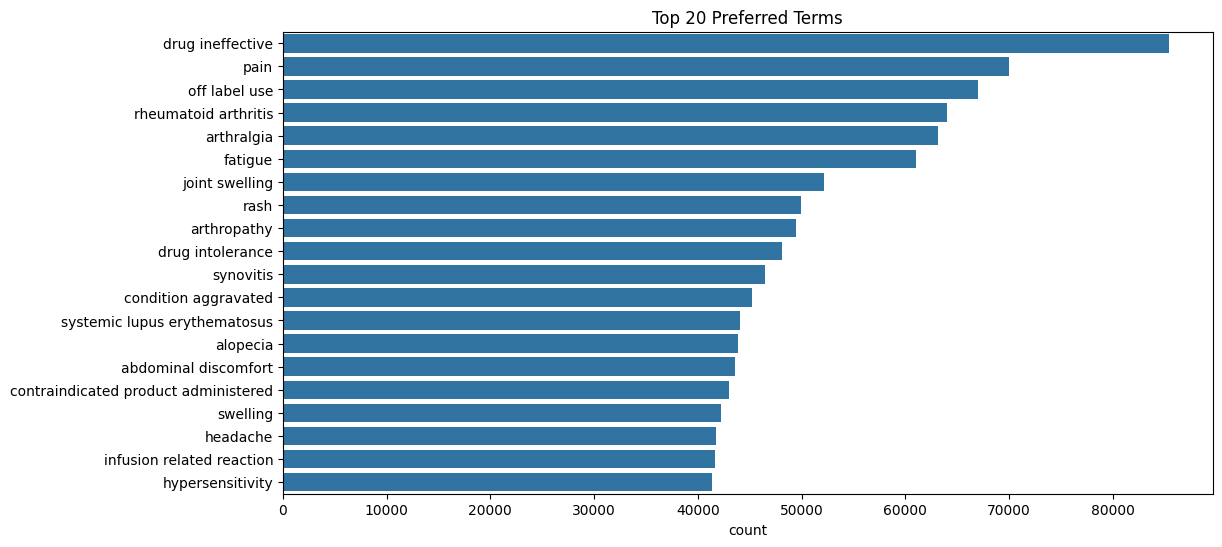

In [65]:
# Plot the distribution of the top 20 preferred terms
plt.figure(figsize=(12, 6))
sns.countplot(y=pts, order=pd.Series(pts).value_counts().index[:20])
plt.title('Top 20 Preferred Terms')
plt.show()

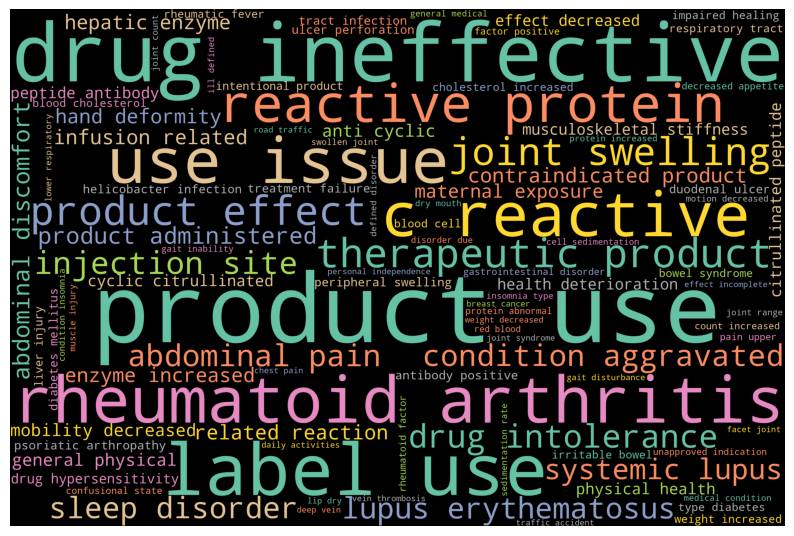

In [66]:
from wordcloud import WordCloud
# Word cloud 
word_list = ' '.join(pts)
wordcloud_pts = WordCloud(
    width=3000,
    height=2000,
    colormap='Set2',
    max_words=100,
    random_state=42
).generate(word_list)

# Display
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_pts)
plt.axis('off')
plt.show()

### 10. Mapping pt to SOC (System Organ Classes)

In [67]:
# Explode the 'pt' column to create a new row for each preferred term
data_3 = data_2.explode('pt', ignore_index=True)

In [68]:
len(data_3), data_3['primaryid'].nunique()

(5502162, 238284)

In [69]:
# Dictionary of System Organ Classes (SOCs) and their corresponding keywords
SOCs_1 = {
    'General disorders and administration site conditions': ['device', 'therapy', 'therapeutic', 'site', 'adverse', 'event', 'hospitalisation', 'pyrexia', 'malaise', 'mobility', 'healing', 'fatigue', 
                                                             'ineffective', 'health', 'asthenia', 'independence', 'breakthrough', 'event', 'weather', 'infusion', 'chills', 'sick', 'life', 'concomitant'],
    'Product issues': ['product', 'label', 'labelled', 'manufacturing'],
    'Surgical and medical procedures': ['surgery', 'surgical', 'operation', 'procedure', 'drainage', 'implant', 'implantation', 'implantable', 'placement', 'replacement', 'repair', 'bypass', 
                                        'insertion', 'removal', 'catheterisation', 'angioplasty', 'aesthesia', 'application', 'intubation', 'endoscopy', 'closure', 'restoration', 'augmentation', 
                                        'intervention', 'eventration', 'excision', 'resection', 'anastomosis', 'decompression', 'anaesthesia', 'restoration', 'diagnostic', 'rehabilitation', 'dialysis'],
    'Social circumstances': ['user', 'abuser', 'family', 'economic', 'work', 'disability', 'care', 'relationship', 'noncompliance', 'diet', 'prescription'],
    'Metabolism and nutrition disorders 1': ['appetite'], 
    'Investigations': ['investigation', 'test', 'measurement', 'present', 'abnormal', 'increased', 'decreased', 'positive', 'negative', 'rate', 'scan', 'examination', 'study', 'stength', 'count', 
                       'biopsy', 'electrocardiogram', 'analysis', 'prolonged', 'polymerase'],
    'Neoplasms benign, malignant and unspecified (incl cysts and polyps)': ['benign', 'malignant', 'neoplasm', 'cancer', 'carcinoma', 'adenoma', 'adenocarcinoma', 'metastatic', 'metastases', 
                                                                            'sarcoma', 'tumour', 'polyp', 'melanoma', 'lymphoma', 'lymphocytic', 'leukaemia', 'polypectomy', 'papilloma', 'lipoma', 
                                                                            'liposarcoma', 'dysplasia', 'hyperplasia', 'leukoplakia', 'stage', 'mass'],
    'Congenital, familial and genetic disorders': ['congenital', 'chromosomal', 'developmental', 'talipes', 'x-linked', 'dna', 'defect', 'gene', 'mutation', 'hereditary', 'delay', 'aplasia', 'stature'],
    'Pregnancy, puerperium and perinatal conditions': ['pregnancy', 'perinatal', 'foetal', 'neonatal', 'maternal', 'postpartum', 'abortion', 'gestational', 'gestation', 'birth', 'umbilical', 
                                                       'placenta', 'placental', 'labour', 'dystocia', 'baby', 'morning', 'lactation'],
    'Infections and infestations': ['infection', 'infectious', 'infective', 'infected', 'infestation', 'viral', 'bacterial', 'bacteraemia', 'fungal', 'parasitic', 'sepsis', 'septic', 'gangrene', 
                                    'cellulitis', 'fever', 'pneumonia', 'tuberculosis', 'covid', 'herpes', 'influenza', 'meningitis', 'abscess', 'osteomyelitis', 'candida', 'mycosis', 
                                    'onychomycosis', 'sinusitis', 'covid-19', 'cytomegalovirus', 'nocardiosis', 'ludwig', 'histoplasmosis', 'meningoencephalitis'],
    'Injury, poisoning and procedural complications': ['injury', 'poisoning', 'burn', 'error', 'use', 'overdose', 'underdose', 'dose', 'radiation', 'amputation', 'abscess', 'contusion', 'haematoma', 
                                                       'anastomotic', 'scratch', 'fall'],
    'Immune system disorders': ['immune', 'autoimmune', 'immune-mediated', 'hypersensitivity', 'allergy', 'anaphylactic', 'rejection', 'immunodeficiency', 'antiphospholipid', 'noninfective'],
    'Blood and lymphatic system disorders': ['anaemia', 'lymphocytosis', 'leukopenia', 'lymphohistiocytosis'],
    'Metabolism and nutrition disorders 2': ['metabolism', 'metabolic', 'nutrition', 'malnutrition', 'vitamin', 'electrolyte', 'deficiency', 'diabetes', 'weight', 'obesity', 'hyperlipidaemia', 
                                           'hypercalcaemia', 'porphyria', 'hypokalaemia', 'dehydration', 'thalassaemia', 'hyperphagia', 'hypophagia', 'fat'],
    'Cardiac disorders': ['cardiac', 'myocardial', 'pericardial', 'pericarditis', 'heart', 'cardiovascular', 'tachycardia', 'atrioventricular', 'valve', 'atrial', 'palpitations', 'branch', 
                          'cardiomyopathy'],
    'Respiratory, thoracic and mediastinal disorders': ['respiratory', 'cardio-respiratory', 'respiration', 'laryngeal', 'laryngitis', 'pharyngeal', 'oropharyngeal', 'pharyngitis', 'nasopharyngitis', 
                                                         'tracheal', 'pleural', 'bronchial', 'bronchitis', 'lung', 'throat', 'nasal', 'paranasal', 'vocal', 'apnoea', 'dyspnoea', 'wheezing', 'cough', 
                                                         'sneezing', 'asthma', 'sputum', 'rhinorrhoea', 'thorax', 'pneumothorax', 'haemothorax', 'rhinitis', 'pleuritic'],
    'Nervous system disorders': ['nervous', 'neurological', 'neuropathy', 'cerebral', 'cerebrovascular', 'cerebrospinal', 'cord', 'seizure', 'seizures', 'convulsion', 'convulsions', 'head', 
                                  'headache', 'migraine', 'dizziness', 'syncope', 'presyncope', 'hypoaesthesia', 'hyperaesthesia', 'paraesthesia', 'dysaesthesia', 'tremor', 'consciousness', 
                                  'stroke', 'epilepsy', 'brain', 'gait', 'sciatica', 'memory', 'psychogenic', 'palsy', 'dementia', 'radiculopathy', 'radiculitis', 'ulnar', 'dyskinesia',
                                  'leishmaniasis', 'myasthenia', 'amnesia', 'blepharospasm', 'somnolence', 'coma', 'dysstasia', 'vertigo', 'jittery', 'paralysis', 'neuralgia', 'speech',
                                  'encephalopathy', 'intracranial', 'ganglia', 'motor', 'subdural', 'subarachnoid', 'balance', 'dysarthria', 'leukoencephalopathy'],
    'Psychiatric disorders': ['psychiatric', 'nervousness', 'depression', 'anxiety', 'mood', 'insomnia', 'hallucination', 'delirium', 'abuse', 'behaviour', 'mental', 'confusional', 'fear', 'sleep',
                              'flashback', 'despair', 'suicide', 'libido', 'sexual', 'personality', 'psychomotor', 'bipolar', 'panic', 'hyperactivity', 'eating', 'amnestic', 'suicide', 'suicidal',
                              'crying'],
    'Eye disorders': ['eye', 'eyes', 'eyelid', 'vision', 'visual', 'ocular', 'ophthalmic', 'retinal', 'conjunctival', 'conjunctivitis', 'corneal', 'foveal', 'scleral', 'glaucoma', 'cataract', 
                      'semicircular', 'keratitis', 'retinopathy', 'chorioretinopathy', 'chorioretinal', 'photosensitivity', 'blindness', 'lens', 'iris', 'vitreous', 'choroidal',
                      'choroiditis', 'lacrimal', 'anterior'],
    'Vascular disorders': ['vascular', 'vasculitis', 'arterial', 'artery', 'arteritis', 'aortic', 'venous', 'vein', 'thrombosis', 'hypertension', 'hypotension', 'embolism', 'vena', 'circulation',
                           'circulatory', 'epistaxis'],
    'Reproductive system and breast disorders': ['reproductive', 'breast', 'genital', 'ovarian', 'testicular', 'prostate', 'penis', 'penile', 'perineal', 'testis', 'uterine', 'scrotal', 
                                                 'vaginal', 'vulvovaginal', 'vulval', 'cervix', 'fallopian', 'erectile', 'nipple', 'male', 'female'],
    'Hepatobiliary disorders': ['hepatic', 'hepatitis', 'biliary', 'liver', 'bile', 'gallbladder', 'splenic', 'cholecystitis', 'cholangitis', 'cholelithiasis'],
    'Renal and urinary disorders': ['renal', 'urine', 'urinary', 'kidney', 'bladder', 'urethral', 'cystitis', 'nephropathy', 'suprapubic'],
    'Ear and labyrinth disorders': ['ear', 'cochlear', 'eustachian', 'labyrinthitis', 'hearing', 'deafness', 'cerumen', 'tympanic'],                                           
    'Gastrointestinal disorders': ['gastrointestinal', 'gastrooesophageal', 'gastroenteritis', 'gastropathy', 'gastric', 'gastritis', 'oesophageal', 'oesophagitis', 'jejunal', 'stomach', 'stoma', 
                                   'stomatitis', 'duodenal', 'duodenitis', 'ileal', 'ileitis', 'pancreatic', 'pancreatitis', 'intestinal', 'intestine', 'colon', 'bowel', 'rectal', 'anorectal', 'anal', 
                                   'oral', 'mouth', 'gingival', 'gingivitis', 'nausea', 'vomit', 'vomiting', 'diarrhoea', 'constipation', 'dyspepsia', 'haematochezia', 'dyschezia', 'hernia', 
                                   'diverticulitis', 'coeliac', 'flatulence', 'dysgeusia', 'ageusia', 'hypogeusia', 'taste', 'satiety', 'proctitis', 'glossitis', 'glossodynia', "crohn's", 'gastroparesis', 
                                   'tongue', 'abdominal', 'peptic', 'faeces', 'defaecation', 'enterocutaneous', 'tonsillar', 'appendicitis'],
    'Endocrine disorders': ['endocrine', 'thyroid', 'thyroiditis', 'hyperthyroidism', 'hypothyroidism', 'parathyroid', 'hormone', 'adrenal', 'pituitary', 'thymus', 'menopause'], 
    'Skin and subcutaneous tissue disorders': ['skin', 'dermal', 'dermatitis', 'pyoderma', 'dermatosis', 'epidermal', 'cutaneous', 'subcutaneous', 'hair', 'face', 'nail', 'lip', 'lips', 'acne',
                                               'alopecia', 'rash', 'scar', 'sweat', 'sweats', 'eczema', 'pemphigus', 'psoriasis', 'folliculitis', 'keratosis', 'hyperkeratosis', 'blister',
                                               'onychomadesis', 'onychomycosis', 'panniculitis', 'hidradenitis', 'urticaria', 'pruritus', 'pityriasis', 'impetigo'],
    'Musculoskeletal and connective tissue disorders': ['musculoskeletal', 'connective', 'muscle', 'muscular', 'skeletal', 'bone', 'joint', 'temporomandibular', 'clavicle', 'humerus', 'rib', 
                                                        'sternal', 'radius', 'ulna', 'patella', 'tibia', 'fibula', 'pelvis', 'sacrum', 'spine', 'coccyx', 'vertebrae', 'vertebral', 'intervertebral', 
                                                        'neck', 'shoulder', 'elbow', 'wrist', 'hand', 'back', 'flatback', 'ankle', 'foot', 'toe', 'hip', 'knee', 'leg', 'legs', 'sacroiliac', 'finger', 
                                                        'limb', 'femur', 'rheumatoid', 'rheumatic', 'rheumatica', 'arthritis', 'polyarthritis', 'osteoarthritis', 'arthralgia', 'arthropathy', 
                                                        'arthroplasty', 'deformity', 'deformans', 'osteoporosis', 'exostosis', 'osteonecrosis', 'osteopenia', 'osteosarcoma', 'spondylitis', 
                                                        'fracture', 'fractures', 'tendon', 'tendonitis', 'tenderness', 'bursitis', 'myalgia', 'fibromyalgia', 'synovial', 'synovitis', 'tenosynovitis', 
                                                        'enthesopathy', 'ligament', 'ankylosis', 'fascial', 'fasciitis', 'soft', 'contracture', 'pubic', 'groin', 'tibial']                     
}

In [70]:
data_3['SOC'] = data_3['pt'].apply(lambda x: next((k for k, v in SOCs_1.items() if any(i in x.replace(',', '').split() for i in v)), None))
data_3['SOC'] = data_3['SOC'].str.replace(r'\s\d+$', '', regex=True)

In [71]:
data_3['SOC'].isnull().sum() / len(data_3) * 100

np.float64(15.26032857629419)

In [72]:
# Save data
data_3.to_csv('data/faers_adalimumab_2020-2024_ungrouped_cleaned_1.csv', index=False)

In [73]:
# Dictionary of System Organ Classes (SOCs) and their corresponding key terms
SOCs_2 = {
    'Surgical and medical procedures': ['omy', 'therapy', 'laryng', 'plasty', 'scopy', 'liposuction', 'surgery', 'clean', 'graft', 'transplant'],
    'General disorders and administration site conditions 1': ['treatment', 'exposure', 'bloody discharge', 'death', 'general', 'illness', 'effect', 'feeling', 'progression', 'recurrence', 'nodule',
                                                               'needle', 'lethargy', 'immunisation'],
    'Social circumstances': ['patient', 'death of', 'self-care'],
    'Product issues': ['device', 'drug delivery'],
    'Pregnancy, puerperium and perinatal conditions': ['foet', 'birth', 'umbilic', 'delivery', 'hydramnios', 'eclampsia', 'cervical'],
    'Reproductive system and breast disorders': ['ovar', 'prostat', 'menstrual', 'endometri', 'menopausal', 'menorrhoea', 'seminal vesicular'],
    'Ear and labyrinth disorders': ['acusis', 'meniere', 'tinnitus'],
    'Investigations 1': ['level', 'antibody', 'c-reactive protein', 'gram', 'risk factor'],
    'Injury, poisoning and procedural complications': ['injur', 'complication', 'wound', 'bite', 'accident', 'procedural haemorrhage', 'haematoma', 'lumbar puncture'],
    'Neoplasms benign, malignant and unspecified (incl cysts and polyps)': ['carcinoma', 'sarcoma', 'lipoma', 'lymphoma', 'fibroma', 'angioma', 'blastoma', 'glioma', 'neuroma', 'gioma', 'myeloma', 
                                                                            'cytoma', 'tumour', 'cancer', 'lymphoproliferative', 'hodgkin', 'plastic'],
    'Congenital, familial and genetic disorders': ['genital', 'newborn'],
    'Cardiac disorders': ['card', 'ventricular', 'valve', 'chest', 'angina'],
    'Blood and lymphatic system disorders': ['thrombotic', 'thrombocy', 'thromboplastin', 'thrombin', 'blood cell', 'blood disorder', 'Lymphocyt', 'platelet'],
    'Vascular disorders': ['arter', 'thromb', 'tension', 'embol', 'ischaem', 'blood pressure', 'lymphoedema', 'circulat', 'arrhythmia', 'raynaud', 'haemorrhage', 'angiopathy', 'flush', 'lymphatic'],
    'Metabolism and nutrition disorders': ['metaboli', 'nutrition', 'vitamin', 'weight', 'mineral', 'dehydration', 'aemia', 'tolerance', 'acidosis', 'height', 'glucose', 'osmolar', 'food'],
    'Eye disorders': ['eye', 'ophthalm', 'retin', 'conjunctiv', 'glaucoma', 'photo', 'optic', 'macular', 'papilloedema', 'orbital', 'uveitis', 'blephar', 'diplopia'],
    'Infections and infestations': ['infect', 'fung', 'parasit', 'sepsis', 'septic', 'pneumo', 'tuberculo', 'mycosis', 'tonsillitis', 'candid', 'viraemia', 'lymphadenitis', 'drug resistance', 
                                    'granuloma', 'lyme', 'whipple', 'vulgaris', 'purulen', 'erysipelas'],
    'Respiratory, thoracic and mediastinal disorders': ['laryn', 'pharyn', 'trach', 'bronch', 'asthma', 'thorax', 'sinus', 'pulmonary', 'nasal', 'phonia', 'crepitations', 'atelectasis', 'catarrh'],
    'Immune system disorders': ['sensitivity', 'allerg', 'sarcoidosis', 'erythematosus', 'granulomatous', 'angioedema', 'lupus-like', 'sjogren'],
    'Skin and subcutaneous tissue disorders': ['dermatitis', 'pemphig', 'psoriasis', 'folliculitis', 'keratosis', 'onych', 'burn', 'erythema', 'drug eruption', 'lichen', 'hidrosis', 'pilonidal',
                                               'furuncle', 'melano', 'papule'],
    'Nervous system disorders': ['nerv', 'neuro', 'cerebr', 'aesthesia', 'kinesia', 'epilept', 'legia', 'limbic', 'spinal pain', 'spinal disorder', 'mening', 'encephalitis', 'sens', 'aphasia', 
                                 'seizure', 'myelin', 'multiple sclerosis', 'phenomenon', 'injury lumbar', 'hydrocephalus', 'movement', 'tunnel', 'parkinson', 'concussion', 'osmia', 'bedridden', 
                                 'ataxia', 'pain syndrome', 'facial pain'],
    'Psychiatric disorders': ['psych', 'depress', 'hallucination', 'depend', 'stress', 'withdrawal', 'feeding', 'emotional', 'hypersomnia', 'irritability', 'nightmare', 'consciousness', 'agitation'],
    'Endocrine disorders': ['thyroid', 'adren', 'pituitar', 'aldosteron', 'androgen', 'addison', 'cushing'], 
    'Renal and urinary disorders': ['renal', 'nephr', 'uria', 'glomerul', 'sclerosis', 'ureter', 'incontinence', 'vesic', 'micturition'],
    'Hepatobiliary disorders': ['hepat', 'bilia', 'portal'],
    'Gastrointestinal disorders': ['gastr', 'oesophag', 'duoden', 'ileus', 'pancrea', 'colon', 'diverticul', 'proct', 'abdominal', 'pseudopolyp', 'anastomotic', 'colitis', 'mucosal', 
                                   'tooth', 'teeth', 'saliva', 'appendic', 'mucosal', 'phagia', 'haemorrhoid', 'dental', 'enteritis', 'pylor', 'mucous', 'aphthous', 'haematemesis'],
    'Musculoskeletal and connective tissue disorders': ['radi', 'patell', 'tibia', 'pelv', 'sacr', 'spinal stenosis', 'vertebr', 'arthr', 'spondyl', 'burs', 'synov', 'osteo', 'grip', 'scleritis',
                                                        'dermatomyositis', 'scleroderma', 'chondr', 'gout', 'fasci', 'brach', 'flank', 'jaw', 'tend', 'lumbar', 'myositis', 'extremity', 'axillary', 
                                                        "still's", 'cuff', 'scoliosis', 'spinal stenosis', 'cartilage'],
    'Investigations 2': ['blood', 'lymphadenopathy', 'interaction', 'normal', 'lymph node'],
    'General disorders and administration site conditions 2': ['condition', 'procedural', 'swelling', 'oedema', 'discomfort', 'ill-defined', 'inflammation', 'fluid', 'pain']
}

In [74]:
data_3.loc[data_3['SOC'].isna(), 'SOC'] = data_3.loc[data_3['SOC'].isna(), 'pt'].apply(
    lambda x: next((k for k, v in SOCs_2.items() if any(i in x for i in v)), None)
)
data_3['SOC'] = data_3['SOC'].str.replace(r'\s\d+$', '', regex=True)

In [75]:
data_3['SOC'].isnull().sum() / len(data_3) * 100

np.float64(0.7442710701720524)

In [76]:
data_3[data_3['SOC'].isna()]['pt'].value_counts()

pt
ulcer                     4798
fistula                   1594
terminal state            1529
cyst                      1515
obstruction                917
                          ... 
enamel anomaly               1
thecal sac compression       1
yao syndrome                 1
bankart lesion               1
omental infarction           1
Name: count, Length: 1132, dtype: int64

In [77]:
# Save data
data_3.to_csv('data/faers_adalimumab_2020-2024_ungrouped_cleaned_2.csv', index=False)

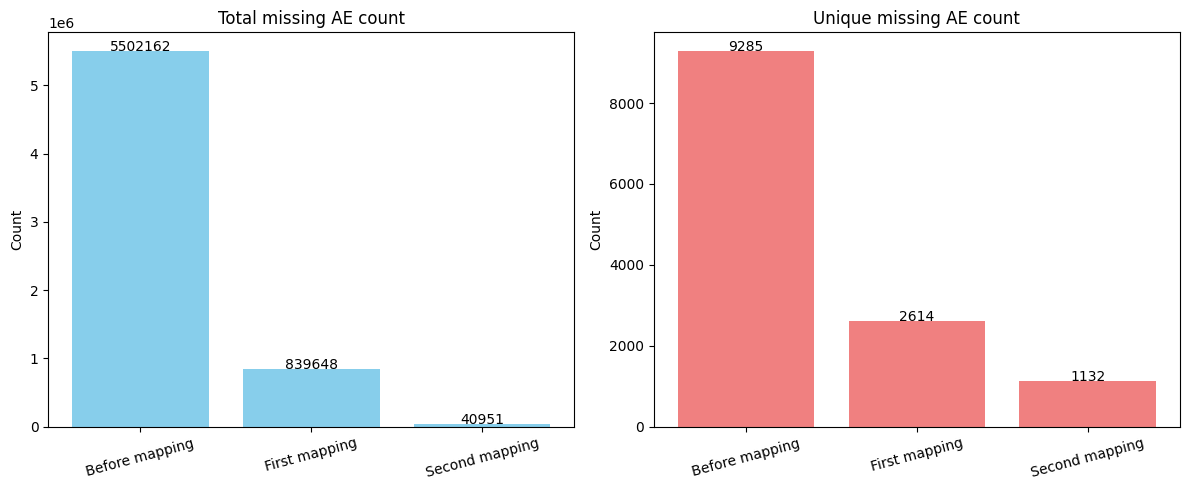

In [78]:
before_mapping = data_2.explode('pt', ignore_index=True)
first_mapping = pd.read_csv('data/faers_adalimumab_2020-2024_ungrouped_cleaned_1.csv')
first_mapping = first_mapping[first_mapping['SOC'].isna()]
second_mapping = pd.read_csv('data/faers_adalimumab_2020-2024_ungrouped_cleaned_2.csv')
second_mapping = second_mapping[second_mapping['SOC'].isna()]

labels = ['Before mapping', 'First mapping', 'Second mapping']
counts = [len(before_mapping), len(first_mapping), len(second_mapping)]
unique_counts = [before_mapping['pt'].nunique(), first_mapping['pt'].nunique(), second_mapping['pt'].nunique()]

x = range(len(labels))
width = 0.35

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First subplot: Total count
ax1.bar(labels, counts, color='skyblue')
ax1.set_title('Total missing AE count')
ax1.set_ylabel('Count')
ax1.set_xticklabels(labels, rotation=15)

# Add count labels
for i, val in enumerate(counts):
    ax1.text(i, val + 1, str(val), ha='center')

# Second subplot: Unique pt count
ax2.bar(labels, unique_counts, color='lightcoral')
ax2.set_title('Unique missing AE count')
ax2.set_ylabel('Count')
ax2.set_xticklabels(labels, rotation=15)

# Add unique count labels
for i, val in enumerate(unique_counts):
    ax2.text(i, val + 1, str(val), ha='center')

plt.tight_layout()
plt.show()

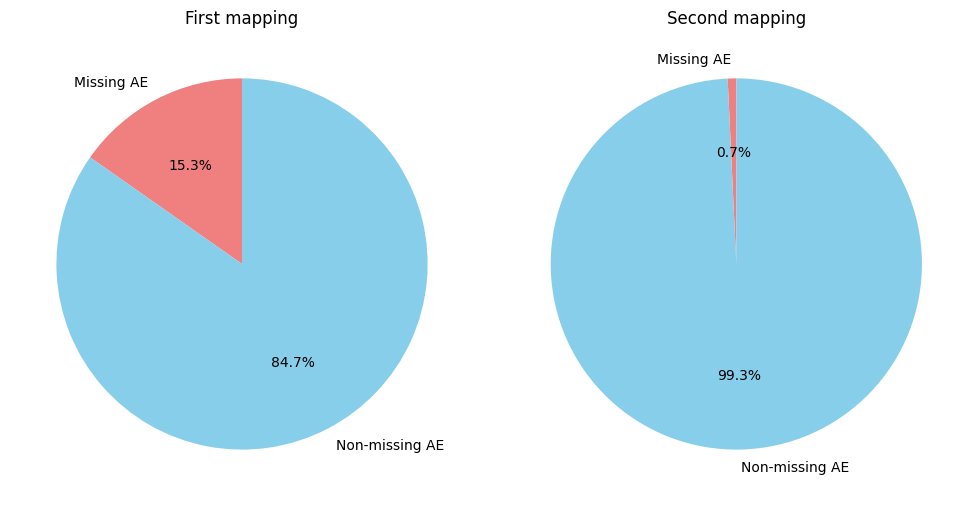

In [79]:
import matplotlib.pyplot as plt

# Total rows in dataset (assuming same total for both mappings)
total_rows = len(before_mapping)

# Prepare data for each mapping
first_missing = len(first_mapping)
first_non_missing = total_rows - first_missing

second_missing = len(second_mapping)
second_non_missing = total_rows - second_missing

# Labels
labels = ['Missing AE', 'Non-missing AE']
colors = ['lightcoral', 'skyblue']

# Plot side-by-side pies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First mapping pie
ax1.pie(
    [first_missing, first_non_missing],
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
ax1.set_title('First mapping')

# Second mapping pie
ax2.pie(
    [second_missing, second_non_missing],
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
ax2.set_title('Second mapping')

plt.tight_layout()
plt.show()

### 11. Create samples for evaluate models

In [80]:
# Create a random sample of 100 rows from the data where 'SOC' is NaN to evaluate validation
random_pt = data_3[data_3['SOC'].isna()].copy()
random_pt = random_pt.drop_duplicates(subset=['pt'])
random_pt = random_pt['pt'].sample(n=100, random_state=42)

# Save data
random_pt.to_csv('data/random_100_pt.csv', index=False)